## Importing Libraries
---

In [3]:
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
import pandas as pd
import time
from tqdm import tqdm 

## Data Scraping (Jia Xiang and Keshen)
---

In [7]:
#Setup the WebDriver
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
#Assign the Snow White (2025) IMDB Reviews link to the driver
driver.get('https://www.imdb.com/title/tt6208148/reviews/?ref_=tt_urv')
#Allows the website to fully load before the driver begins the scraping provess to prevent being rate limited
driver.implicitly_wait(10)

#Search for and click the "All" button near the vertical scroll end of the website
try:
    all_button = WebDriverWait(driver, 5).until(
        EC.element_to_be_clickable((By.XPATH, "//button[.//span[@class='ipc-see-more__text' and text()='All']]"))
    )
    driver.execute_script("arguments[0].click();", all_button)
    time.sleep(2)  
except:
    pass  

# Scroll to load all 
count = 0
scroll = 0

while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  
    
    mains = driver.find_elements(By.CLASS_NAME, "ipc-list-card__content")
    
    if len(mains) == count: 
        scroll += 1
        if scroll > 5:  
            break  
    else:
        scroll = 0  
    
    count = len(mains)

# Scroll again for final check
for _ in range(3):  
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  

# Review and rating
mains = driver.find_elements(By.CLASS_NAME, "ipc-list-card__content")
all_reviews = []
all_ratings = []


for main in tqdm(mains):
    # Review
    ret = main.find_elements(By.CLASS_NAME, "ipc-html-content-inner-div")
    review = ret[0].text.strip() if ret else ""  

    # Rating
    rat = main.find_elements(By.CLASS_NAME, "sc-3e6f8aa9-4")
    rating = f"{rat[0].text.strip().split('\n')[0]}/10" if rat else ""  

    all_reviews.append(review)
    all_ratings.append(rating)

imdb = {
    'Review': all_reviews,
    'Rating': all_ratings,
}

# CSV
df = pd.DataFrame(imdb)
df.fillna("", inplace=True)  
df.to_csv('imdb.csv', index=False)
driver.quit()
df

100%|██████████| 1194/1194 [22:32<00:00,  1.13s/it]


,Review,Rating
0,Disney's live-action Snow White is finally her...,1/10
1,"As always, whenever there's a negative hype ar...",1/10
2,"Disney's latest live-action remake, Snow White...",1/10
3,Saw this at the cinema with my six-year-old da...,1/10
4,Snow White remake set out to modernize the cla...,1/10
...,...,...
1189,As someone who never cared much for the origin...,9/10
1190,"I have seen bad movies before, but this one ta...",1/10
1191,,7/10
1192,I viewed Snow White this weekend and found it ...,10/10


## Data Cleaning and Sentiment Analysis (Thaddeus)

In [44]:
df = pd.read_csv('./imdb.csv')
df.head()

,Review,Rating
0,Disney's live-action Snow White is finally her...,1/10
1,"As always, whenever there's a negative hype ar...",1/10
2,"Disney's latest live-action remake, Snow White...",1/10
3,Saw this at the cinema with my six-year-old da...,1/10
4,Snow White remake set out to modernize the cla...,1/10


In [46]:
import nltk
nltk.__version__
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

In [48]:
nltk.download('punkt_tab') # for tokenisation
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng') # POS tagging Part of speech tagging
nltk.download('wordnet') # lemmatization
nltk.download('vader_lexicon') # sentiment analysis

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [50]:
## preps data to be run thru sentiment analysis
def preprocess (data):
    words = word_tokenize(data)
    stop_words = set(stopwords.words('english'))
    normalize_words = [word.lower() for word in words if word.isalpha()]
    filtered_words = [word for word in normalize_words if word not in stop_words]
    text = ' '.join(filtered_words)
    return text

In [52]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiments(df):
    # default vals
    df['Cleaned_Review'] = ''
    df['VADER_Compound'] = 0.0
    df['VADER_Positive'] = 0.0
    df['VADER_Negative'] = 0.0
    df['VADER_Neutral'] = 0.0
    
    # processing review
    for i in range(len(df)):
        review_text = df.loc[i, 'Review']
    # make to empty string (if not: float error)
        if type(review_text) != str:
            review_text = ""
        
        # cuci before analyze
        clean = preprocess(review_text)
        #print(clean_review)
        df.at[i, 'Cleaned_Review'] = clean
        # sentiment analysis
        sentiment_scores = sia.polarity_scores(clean)
        df.at[i, 'VADER_Compound'] = sentiment_scores['compound']
        df.at[i, 'VADER_Positive'] = sentiment_scores['pos']
        df.at[i, 'VADER_Negative'] = sentiment_scores['neg']
        df.at[i, 'VADER_Neutral'] = sentiment_scores['neu']

    file = 'imdb_sentiment_analysis.csv'
    df.to_csv(file, index=False)
    print(f"done, saved to {file}.")

    return df


In [54]:
df = analyze_sentiments(df)

done, saved to imdb_sentiment_analysis.csv.


## Word Cloud (Leong)
---

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

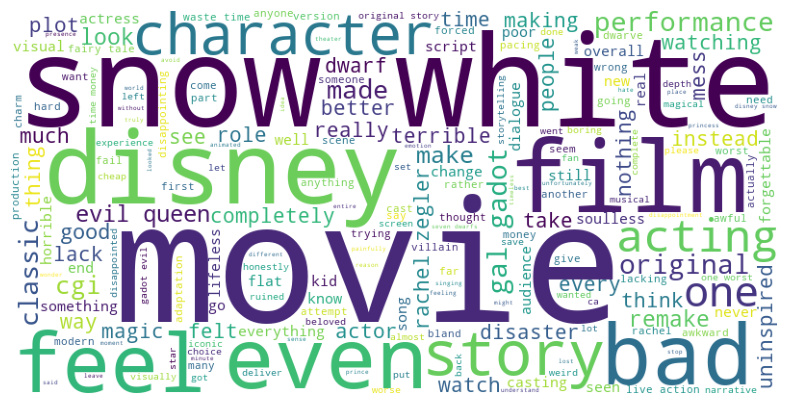

In [57]:
wc = WordCloud(width=800,height=400,background_color='white').generate(' '.join(df[df['VADER_Compound'] <= -0.05]['Cleaned_Review'].values))
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

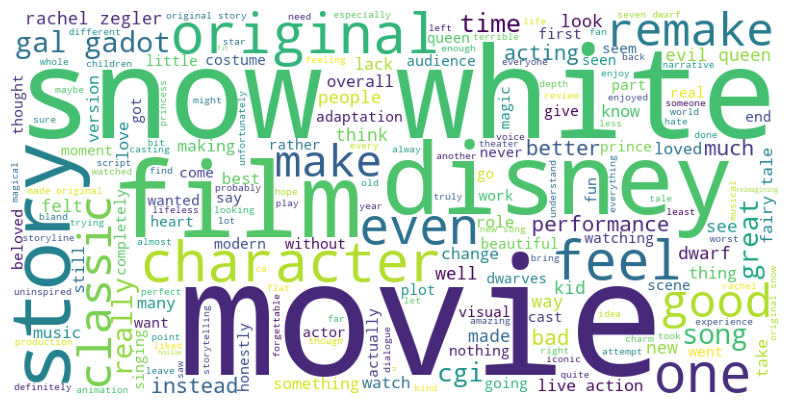

In [58]:
wc = WordCloud(width=800,height=400,background_color='white').generate(' '.join(df[df['VADER_Compound'] >= 0.05]['Cleaned_Review'].values))
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

## Sentiment Distribution (Jia Xiang)
---

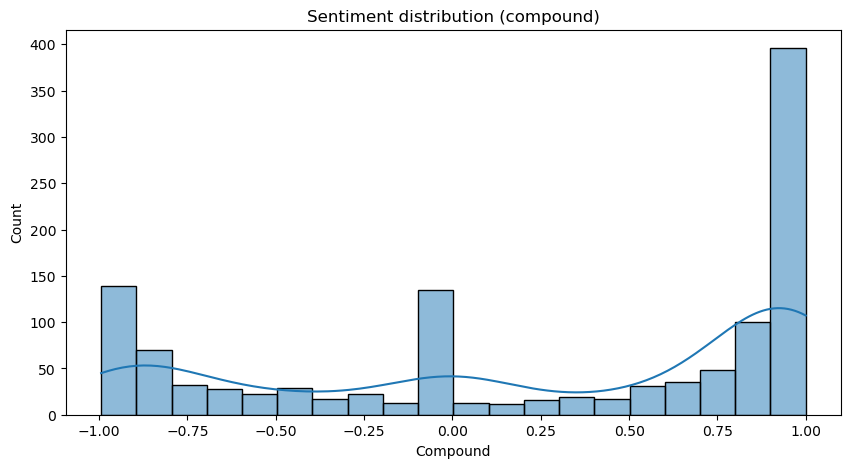

In [62]:
plt.figure(figsize=(10,5))
sns.histplot(df['VADER_Compound'], bins=20, edgecolor='black', kde=True)
plt.title('Sentiment distribution (compound)')
plt.xlabel('Compound')
plt.show()

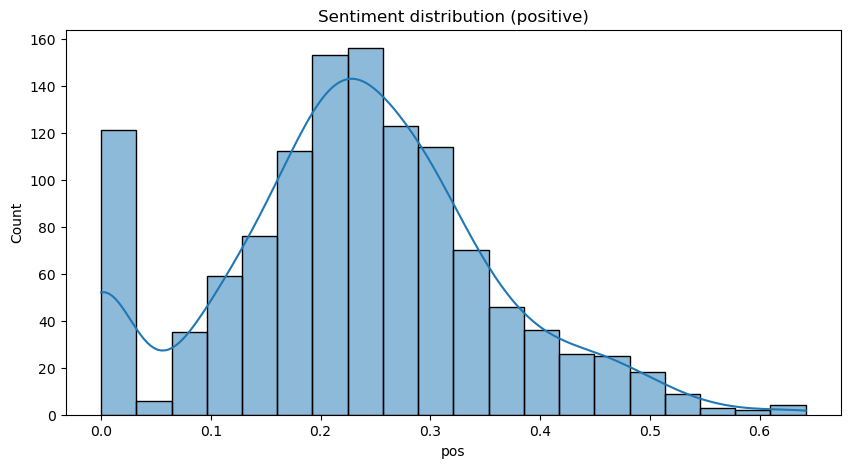

In [64]:
plt.figure(figsize=(10,5))
sns.histplot(df['VADER_Positive'], bins=20, edgecolor='black', kde=True)
plt.title('Sentiment distribution (positive)')
plt.xlabel('pos')
plt.show()

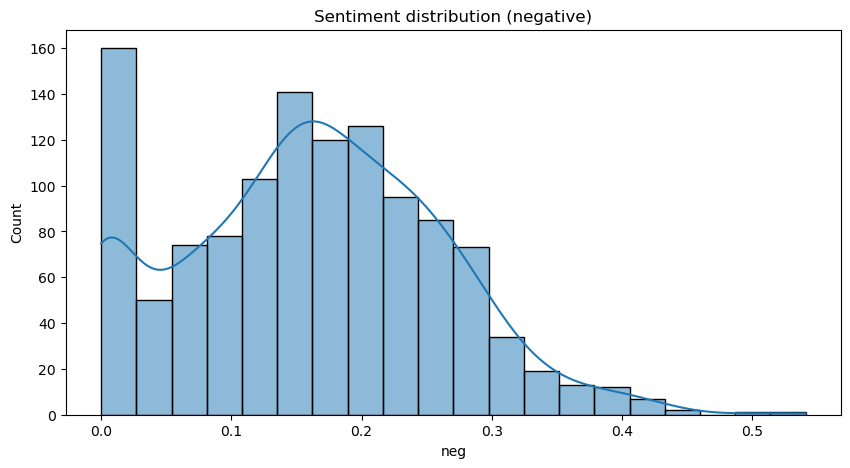

In [66]:
plt.figure(figsize=(10,5))
sns.histplot(df['VADER_Negative'], bins=20, edgecolor='black', kde=True)
plt.title('Sentiment distribution (negative)')
plt.xlabel('neg')
plt.show()

## Standard Deviation (Jia Xiang)
---

In [71]:
import numpy as np  

# Make it to float and drop '' data
df['New_Rating'] = df['Rating'].str.replace('/10', "", regex=True).astype(float)
sd = np.std(df['New_Rating'].dropna())
sd

3.122885069946158

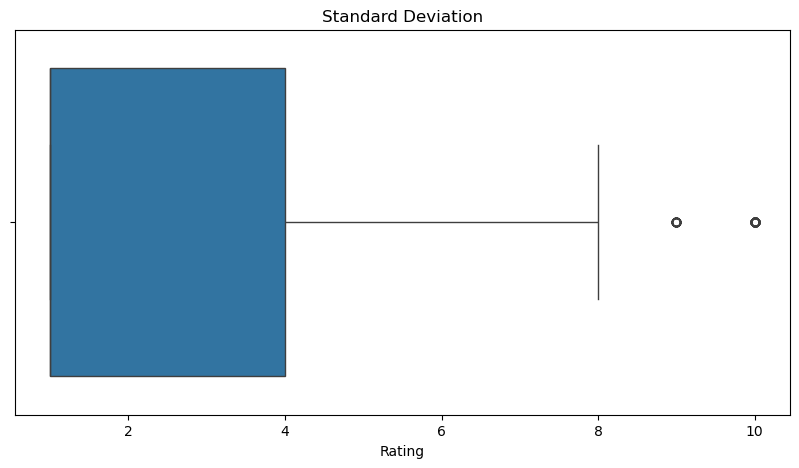

In [73]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['New_Rating'])
plt.title('Standard Deviation')
plt.xlabel('Rating')
plt.show()


## Normal Distribution (Jia Xiang)
---

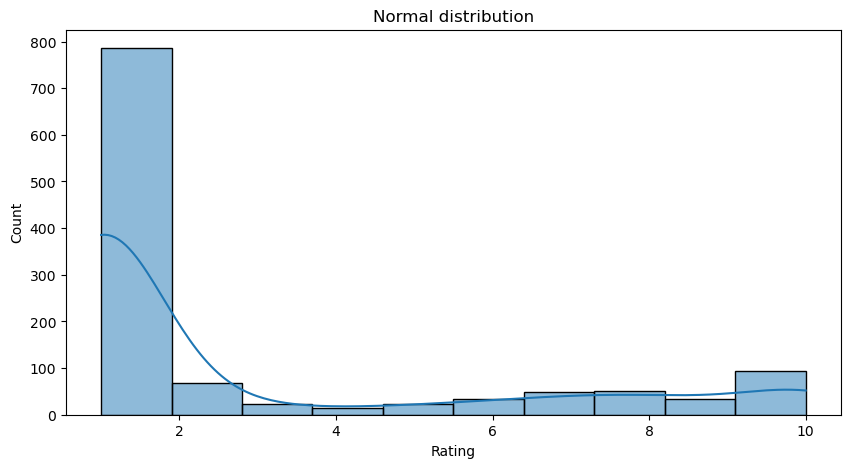

In [76]:
plt.figure(figsize=(10,5))
sns.histplot(df['New_Rating'], bins=10, kde='True', edgecolor='black')
plt.title('Normal distribution')
plt.xlabel('Rating')
plt.show()

## Ratio (Jia Xiang)
---

In [79]:
import math

# Positve (6-10) and negative reviews (1-5)
pr = (df['New_Rating'] >= 6).sum() 
nr = (df['New_Rating'] <= 5).sum()  

# Avoid division by zero
if pr > 0:
    # Round the ratio
    ratio = nr // pr 
    zzz = f"{nr}:{pr}"  
else:
    zzz = 'Nothing here...'

zzz

'916:261'

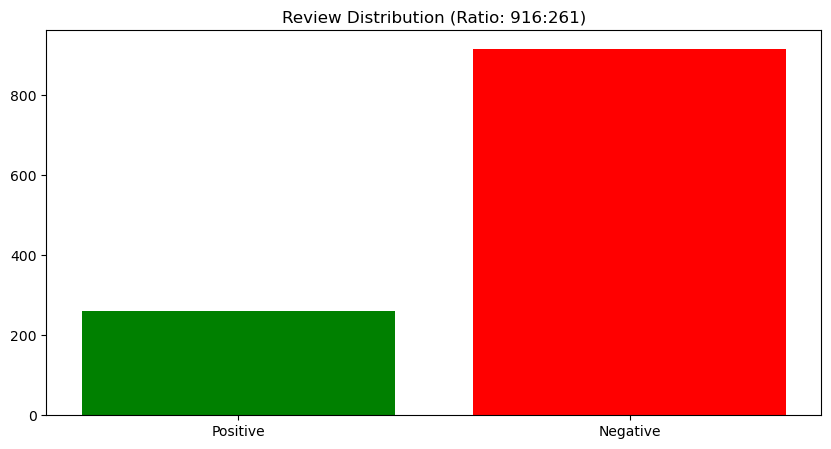

In [81]:
review = ['Positive', 'Negative']
values = [pr, nr]

plt.figure(figsize=(10, 5))
plt.bar(review, values, color=['green', 'red'])
plt.title(f"Review Distribution (Ratio: {zzz})")
plt.show()

# Redoing Negative Review Analysis (Keshen)
- Removing common neutral and movie related words
---

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


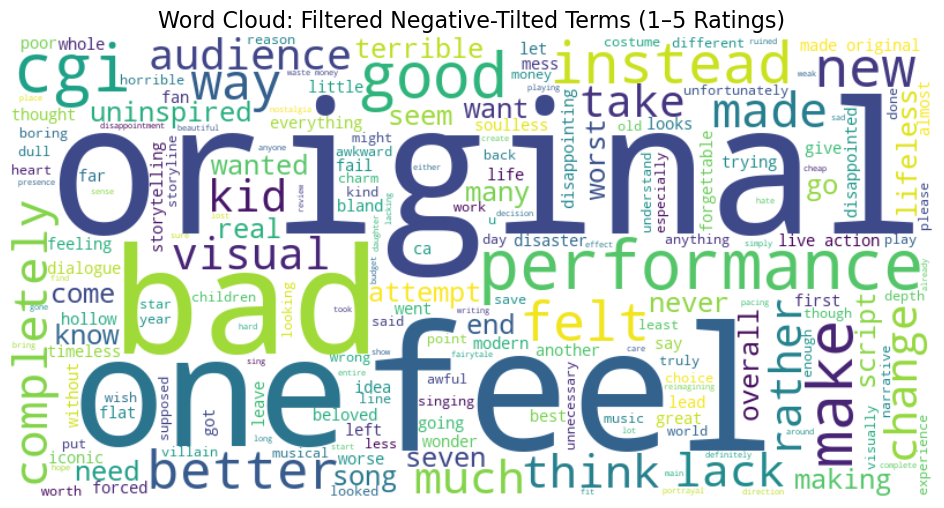

In [84]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Download stopwords if needed
nltk.download('stopwords')

# Load data
df = pd.read_csv("./imdb_sentiment_analysis.csv")

# Filter for ratings 1 to 5
df = df[df['Rating'].str.extract(r'(\d+)')[0].astype(float).between(1, 5)]

# Combine all cleaned reviews
text = " ".join(df["Cleaned_Review"].dropna().tolist())

# Base English stopwords
stop_words = set(stopwords.words("english"))

# Add domain-specific neutral terms
custom_stopwords = {
    # Characters & Cast
    "snow", "white", "snowwhite", "princess", "evil", "queen", "stepmother",
    "huntsman", "dwarf", "dwarfs", "dwarves", "rachel", "zegler", "gal",
    "gadot", "galgadot", "rachelzegler", "prince", "character", "characters",

    # Production / Movie-related
    "disney", "movie", "movies", "film", "films", "remake", "remakes", "version",
    "versions", "adaptation", "adaptations", "liveaction", "animated", "animation",
    "produced", "production", "producing", "director", "directors", "studio",
    "studios", "scene", "scenes", "role", "roles", "acting", "acted", "cast",
    "casting", "actor", "actors", "actress", "actresses", "hollywood", "release",
    "releases", "released", "releasing", "date", "dates", "trailer", "trailers",

    # Plot / Story Concepts
    "story", "stories", "plot", "plots", "magic", "magical", "mirror", "mirrors",
    "forest", "forests", "castle", "castles", "fairy", "fairies", "tale", "tales",
    "classic", "classics", "apple", "apples", "poisoned", "poison", "spell",
    "spells", "kiss", "kisses", "kissed", "kissing", "wedding", "weddings", "love",
    "loved", "loving", "romance", "romantic", "hero", "heroes", "heroine",
    "heroines", "journey", "journeys", "adventure", "adventures",

    # Viewer Language
    "watch", "watched", "watching", "viewer", "viewers", "viewing", "see", "seen",
    "seeing", "theater", "theaters", "cinema", "cinemas", "screen", "screens",
    "time", "times", "thing", "things", "part", "parts", "moment", "moments",
    "like", "liked", "likes", "liking", "just", "really", "quite", "bit", "bits",
    "every", "everyone", "nothing", "something", "someone", "people", "person",

    # Filler Words / Speech Disfluencies
    "um", "uh", "oh", "hmm", "huh", "well", "so", "actually", "basically", 
    "literally", "honestly", "seriously", "kinda", "sorta", "maybe", "perhaps",
    "anyway", "anyways", "yeah", "yes", "no", "ok", "okay", "right", "alright",
    "hey", "look", "guess", "thing", "things", "mean", "even", "still"
}

stop_words.update(custom_stopwords)

# Remove stopwords and neutral words
filtered_words = [
    word for word in text.split() if word.lower() not in stop_words
]

# Join into one string
filtered_text = " ".join(filtered_words)

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(filtered_text)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Filtered Negative-Tilted Terms (1–5 Ratings)", fontsize=16)
plt.show()

# Redoing Positive Review Analysis (Keshen)
- Removing common neutral and movie related words
---

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jia99\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


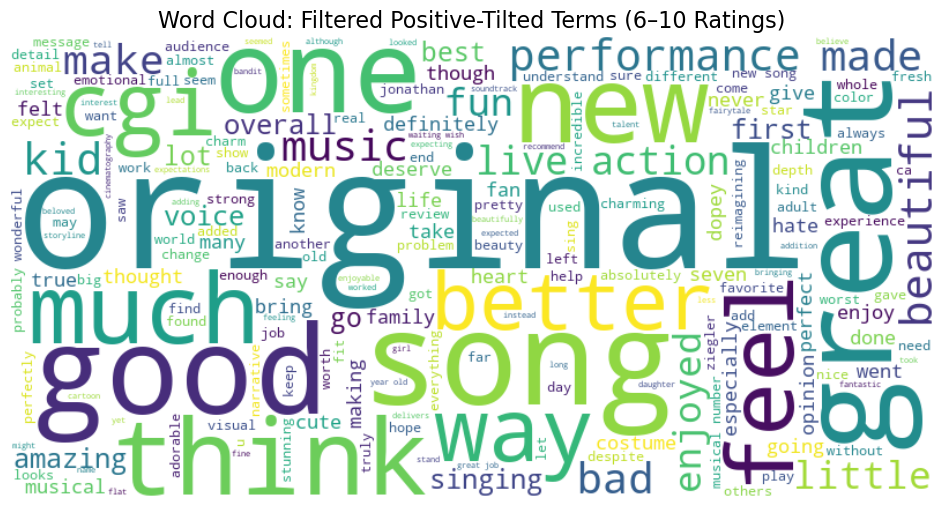

In [87]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Download stopwords if needed
nltk.download('stopwords')

# Load data
df = pd.read_csv("./imdb_sentiment_analysis.csv")

# Filter for ratings 1 to 5
df = df[df['Rating'].str.extract(r'(\d+)')[0].astype(float).between(6, 10)]

# Combine all cleaned reviews
text = " ".join(df["Cleaned_Review"].dropna().tolist())

# Base English stopwords
stop_words = set(stopwords.words("english"))

# Add domain-specific neutral terms
custom_stopwords = {
    # Characters & Cast
    "snow", "white", "snowwhite", "princess", "evil", "queen", "stepmother",
    "huntsman", "dwarf", "dwarfs", "dwarves", "rachel", "zegler", "gal",
    "gadot", "galgadot", "rachelzegler", "prince", "character", "characters",

    # Production / Movie-related
    "disney", "movie", "movies", "film", "films", "remake", "remakes", "version",
    "versions", "adaptation", "adaptations", "liveaction", "animated", "animation",
    "produced", "production", "producing", "director", "directors", "studio",
    "studios", "scene", "scenes", "role", "roles", "acting", "acted", "cast",
    "casting", "actor", "actors", "actress", "actresses", "hollywood", "release",
    "releases", "released", "releasing", "date", "dates", "trailer", "trailers",

    # Plot / Story Concepts
    "story", "stories", "plot", "plots", "magic", "magical", "mirror", "mirrors",
    "forest", "forests", "castle", "castles", "fairy", "fairies", "tale", "tales",
    "classic", "classics", "apple", "apples", "poisoned", "poison", "spell",
    "spells", "kiss", "kisses", "kissed", "kissing", "wedding", "weddings", "love",
    "loved", "loving", "romance", "romantic", "hero", "heroes", "heroine",
    "heroines", "journey", "journeys", "adventure", "adventures",

    # Viewer Language
    "watch", "watched", "watching", "viewer", "viewers", "viewing", "see", "seen",
    "seeing", "theater", "theaters", "cinema", "cinemas", "screen", "screens",
    "time", "times", "thing", "things", "part", "parts", "moment", "moments",
    "like", "liked", "likes", "liking", "just", "really", "quite", "bit", "bits",
    "every", "everyone", "nothing", "something", "someone", "people", "person",

    # Filler Words / Speech Disfluencies
    "um", "uh", "oh", "hmm", "huh", "well", "so", "actually", "basically", 
    "literally", "honestly", "seriously", "kinda", "sorta", "maybe", "perhaps",
    "anyway", "anyways", "yeah", "yes", "no", "ok", "okay", "right", "alright",
    "hey", "look", "guess", "thing", "things", "mean", "even", "still"
}

stop_words.update(custom_stopwords)

# Remove stopwords and neutral words
filtered_words = [
    word for word in text.split() if word.lower() not in stop_words
]

# Join into one string
filtered_text = " ".join(filtered_words)

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(filtered_text)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Filtered Positive-Tilted Terms (6–10 Ratings)", fontsize=16)
plt.show()